In [1]:
from create_data_single import Circ as cc
from dgcnsuq import DGCN as cn
import matplotlib
import matplotlib.pyplot as plt

In [2]:
data_instance = cc(0.4, 0.4, 0.2, 26)
fpc, fnc, pc, lp, tc, lt = data_instance.create_dataset(5, 1, [100], [0.2], True, 10)

In [3]:
import torch
torch.manual_seed(26)
fpc, fnc, pc, lp, tc, lt = torch.tensor(fpc), torch.tensor(fnc), torch.tensor(pc), torch.tensor(lp), torch.tensor(tc), torch.tensor(lt)

In [4]:
pc.view(-1, pc.size(-1)).shape

torch.Size([280, 2])

In [5]:
training_data = pc.reshape(-1, pc.size(-1))
test_data = tc[0]
noise_var = 0.01
training_label = noise_var * torch.randn(training_data.size(0))
test_label = torch.Tensor(test_data.size(0))

In [6]:
training_data.shape

torch.Size([280, 2])

In [7]:
model = cn(training_data, test_data, training_label, test_label, False, 2, noise_var)

In [8]:
model.train_kernel(num_epochs=100, batch_size=20, learning_rate=0.00005, print_every=3)

tensor(5.2889e-28, grad_fn=<LinalgDetBackward0>)
tensor(2.9189e-28, grad_fn=<LinalgDetBackward0>)
tensor(2.8909e-27, grad_fn=<LinalgDetBackward0>)
tensor(2.0173e-27, grad_fn=<LinalgDetBackward0>)
tensor(2.8510e-27, grad_fn=<LinalgDetBackward0>)
tensor(7.5857e-27, grad_fn=<LinalgDetBackward0>)
tensor(2.3408e-27, grad_fn=<LinalgDetBackward0>)
tensor(1.1451e-26, grad_fn=<LinalgDetBackward0>)
tensor(1.2875e-26, grad_fn=<LinalgDetBackward0>)
tensor(6.1150e-27, grad_fn=<LinalgDetBackward0>)
tensor(4.7197e-28, grad_fn=<LinalgDetBackward0>)
tensor(3.6854e-27, grad_fn=<LinalgDetBackward0>)
tensor(2.3264e-27, grad_fn=<LinalgDetBackward0>)
tensor(2.4692e-27, grad_fn=<LinalgDetBackward0>)
Epoch:0, Loss: -12.200495174952916
tensor(3.2351e-28, grad_fn=<LinalgDetBackward0>)
tensor(1.7384e-28, grad_fn=<LinalgDetBackward0>)
tensor(1.6978e-27, grad_fn=<LinalgDetBackward0>)
tensor(1.1828e-27, grad_fn=<LinalgDetBackward0>)
tensor(1.6864e-27, grad_fn=<LinalgDetBackward0>)
tensor(4.2793e-27, grad_fn=<Linalg

/servers/ash/hdd-home3/dghosh/Documents/Thesis/1notebooks/dgcnsuq.py:9: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1724788960438/work/aten/src/ATen/native/TensorShape.cpp:3697.)
  dist_term = -0.5 * (label - mean).T @ torch.linalg.inv(variance) @ (label - mean)


Epoch:9, Loss: -15.557596292127101
tensor(3.8627e-30, grad_fn=<LinalgDetBackward0>)
tensor(3.1418e-30, grad_fn=<LinalgDetBackward0>)
tensor(2.5140e-29, grad_fn=<LinalgDetBackward0>)
tensor(1.4805e-29, grad_fn=<LinalgDetBackward0>)
tensor(1.4361e-29, grad_fn=<LinalgDetBackward0>)
tensor(5.6840e-29, grad_fn=<LinalgDetBackward0>)
tensor(1.6086e-29, grad_fn=<LinalgDetBackward0>)
tensor(4.8832e-29, grad_fn=<LinalgDetBackward0>)
tensor(5.5877e-29, grad_fn=<LinalgDetBackward0>)
tensor(3.3547e-29, grad_fn=<LinalgDetBackward0>)
tensor(3.1493e-30, grad_fn=<LinalgDetBackward0>)
tensor(3.1636e-29, grad_fn=<LinalgDetBackward0>)
tensor(7.3747e-30, grad_fn=<LinalgDetBackward0>)
tensor(1.7740e-29, grad_fn=<LinalgDetBackward0>)
tensor(2.2998e-30, grad_fn=<LinalgDetBackward0>)
tensor(2.0676e-30, grad_fn=<LinalgDetBackward0>)
tensor(1.6451e-29, grad_fn=<LinalgDetBackward0>)
tensor(9.2567e-30, grad_fn=<LinalgDetBackward0>)
tensor(8.3580e-30, grad_fn=<LinalgDetBackward0>)
tensor(3.7048e-29, grad_fn=<Linalg

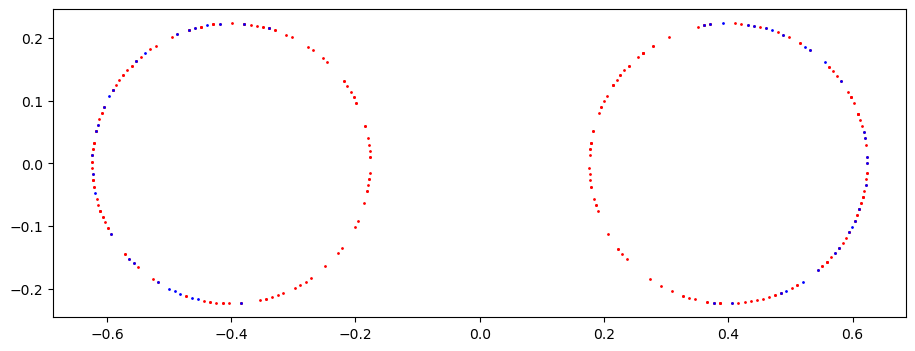

In [9]:
fig = plt.figure(figsize=(11, 4))
ax = fig.add_subplot(111)
ax.scatter(training_data.cpu().numpy()[:, 0], training_data.cpu().numpy()[:, 1], c='r', s=1)
ax.scatter(test_data.cpu().numpy()[:, 0], test_data.cpu().numpy()[:, 1], c='b', s=1)

Text(0.5, 1.0, 'Probability of being on the surface')

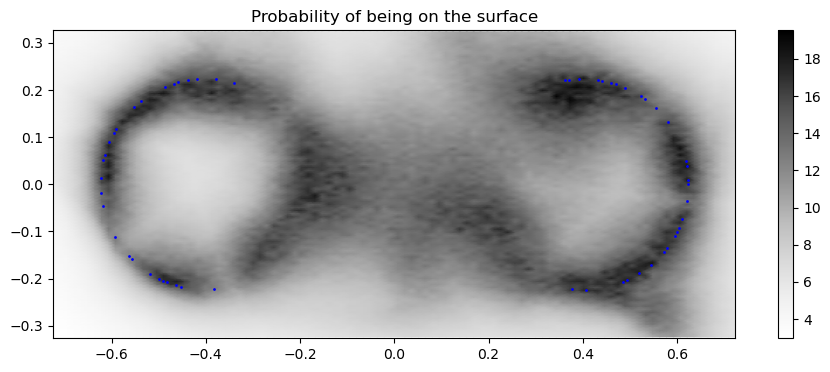

In [10]:
import numpy as np
from scipy.stats import norm
grid_sizes = np.ones(2, dtype=np.int32) * 100
def create_grid(box_min=None, box_max=None, eps=0.1):
    # find the bounding box for all dataset
    if box_min is None:
        box_min = torch.amin(test_data, 0) - eps
    if box_max is None:
        box_max = torch.amax(test_data, 0) + eps

    # Build a grid (dimension-agnostic)
    grid_vertices = np.meshgrid(
        *[np.linspace(box_min[d], box_max[d], grid_sizes[d]) for d in range(2)])
    grid_vertices = np.stack(grid_vertices, axis=-1).reshape(-1, 2)
    grid_vertices = torch.tensor(grid_vertices, dtype=torch.float32)
    return grid_vertices
grid_data = create_grid()
grid_label = torch.Tensor(grid_data.size(0))
training_label = noise_var * torch.randn(test_data.size(0))
pm, pv = model.compute_posterior_batch(test_data, training_label, grid_data, grid_label, True)
pd = torch.diagonal(pv, 0)
with torch.no_grad():
    prob_on_surface = norm.pdf(np.zeros(pm.shape), loc=pm.cpu().detach().numpy(),
                               scale=np.sqrt(pd.cpu().detach().numpy()))
gp = grid_data.cpu().numpy()
gp_x = gp[:, 0].reshape(grid_sizes)
gp_y = gp[:, 1].reshape(grid_sizes)
gp_prob = prob_on_surface.reshape(grid_sizes)

fig = plt.figure(figsize=(11, 4))
ax = fig.add_subplot(111)
plot = ax.pcolormesh(gp_x, gp_y, gp_prob, shading='gouraud', cmap='Greys')
ax.scatter(test_data.cpu().numpy()[:, 0], test_data.cpu().numpy()[:, 1], c='b', s=1)
fig.colorbar(plot)
ax.axis('equal')
ax.set_title(f'Probability of being on the surface')